<a href="_index.ipynb">&larr; FIX </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>
# FIX: Fixpoint-Quantisierung im Zeitbereich #
## Grenzzyklen ##

In diesem Notebook wird gezeigt, wie bei IIR - Filtern Quantisierung zu Grenzzyklen oder "Zero-Input Limit Cycles" führen kann, d.h. zu Ausgangssignalen, die auch nach Ende des Eingangssignals nicht ausklingen. Grenzzyklen können als periodische Signale, als DC-Offset oder auch als chaotische Signale auftreten.

In [1]:
import os, sys
import time
import numpy as np

module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_lib as dsp # import and set plot properties
import dsp_fpga_fix_lib as fx

%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('../script.mplstyle')
figsize = {"figsize":(13,7)}

## Simulation
Um den Einfluss von Quantisierung, Überlauf etc. auf die Eigenschaftgen eines Filters (oder eines anderen zeitdiskreten Systems) zu sehen, muss man das Filter im Zeitbereich simulieren. Alle anderen Analysemethoden (P/N-Diagramm, `freqz()` etc.) nutzen die z-Transformation, die nur für LTI-Systeme definiert ist. Quantisierung und Überlauf-/Sättigungseffekte sind aber nichtlineare Effekte!

Im folgenden werden ein IIR-Filter erster und ein IIR-Filter zweiter Ordnung definiert, bei denen das Ausgangssignal vor der Rückführung quantisiert wird.

In [2]:
def IIR1(q_inst, x, a):
    """
    Rekursives Filter mit y[i] = Q< x[i-1] + a y[i-1] >
    """
    y = np.zeros(len(x))
    for i in range(0,len(x)-1):
        y[i+1] = q_inst.fixp(x[i] + a * y[i])
    return y
    
def IIR2(q_inst, x, a):
    """
    Rekursives Filter mit y[i] = Q< x[i-2] + y[i-1] - a y[i-2] >
    """
    y = np.zeros(len(x))
    for i in range(len(x)-2):
        y[i+2] = q_inst.fixp(x[i] + y[i+1] - y[i]*a)
    return y

Bei rekursiven (IIR-)Filtern können Quantisierung und Überläufe zu sog. "Zero-Input Limit Cycles" führen, d.h. am Ausgang des Filters liegt ein andauerndes periodisches oder DC-Signal an, obwohl das Eingangssignal längst abgeschaltet wurde.

- **Kleine Grenzzyklen** können entstehen, wenn beim Runden der Betrag des Signals wächst (Energie wird zugeführt). Das kann (vorzeichenabhängig) z.B. bei `round` und `floor` auftreten. Beim Betragsschneiden wird der Betrag niemals größer, damit werden Grenzzyklen vermieden. Versuchen Sie beim IIR1 Filter die Einstellung
`alpha = +/-0.9` und `q_accu = {'Q':(0,4),'quant':'round','ovfl':'sat'}`

- **Große Grenzzyklen** können durch Überläufe angeregt werden. Durch Sättigung werden große Grenzzyklen vermieden. Versuchen Sie beim IIR2 Filter die Einstellung
`alpha = +0.9`, `x[0] = 1` und `q_accu = {'Q':(0,4),'quant':'round','ovfl':'wrap'}`

Versuchen Sie auch einmal 'floor' und 'sat' für Quantisierung bzw. Überlauf.

Rechenzeit: 8.17 ms für 199 Quantisierungen
Anzahl Überläufe =  1


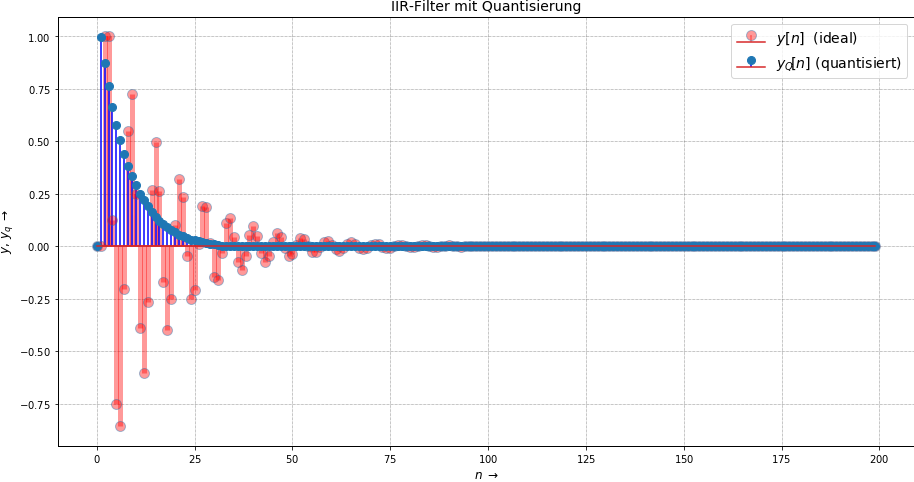

In [3]:
alpha = 0.93 # Koeffizient
N_sim = 200 # Anzahl Simulationsschritte

x = np.zeros(N_sim); x[0] = 1.0 # x ist dirac-Stoß mit Gew. 1.0

 # Koeffizientenquantisierung:
q_coeff = {'WI':0,'WF':3,'quant':'round','ovfl':'wrap'}
 # Quantisierung nach Summation im Filter:
#q_accu = {'WI':0,'WF':4,'quant':'fix','ovfl':'sat'} # keine Grenzzyklen
q_accu = {'Q':0.8,'quant':'fix','ovfl':'sat'}  # große Grenzzyklen bei QI = 0
# kleine Grenzzyklen mit round / floor, abhängig von alpha:
# q_accu = {'WI':0,'WF':4,'quant':'floor','ovfl':'wrap'} 

# Keine Quantisierung ->  Werte für I, F beliebig
q_ideal = {'WI':0,'WF':0,'quant':'none','ovfl':'none'}

fx_coeff = fx.Fixed(q_coeff) # Fixpoint Object mit Parametern "q_coeff"
alpha_q  = fx_coeff.fixp(alpha) # berechne  quantisierten Koeffizienten

fx_IIR_id = fx.Fixed(q_ideal) # Fixpoint-Objekt ohne Quantisierung und Overflow 
fx_IIR = fx.Fixed(q_accu) # Fixpoint-Objekt mit Parametern "q_accu"

n = np.arange(N_sim)
t1 = time.perf_counter()

y = IIR2(fx_IIR_id, x, alpha_q) # ohne Quantisierung
#yq = IIR2(fx_IIR, x, alpha_q)
yq = IIR1(fx_IIR, x, alpha_q)
#
t2 = time.perf_counter()
print('Rechenzeit: {0:.3g} ms für {1} Quantisierungen'.format((t2-t1)*1000, fx_IIR.N))
print('Anzahl Überläufe = ', fx_IIR.N_over)

fig1, ax1 = plt.subplots(**figsize); ax1.grid(True)
ax1.set_title('IIR-Filter mit Quantisierung')

mly, sly, bly = ax1.stem(n,y, label = r'$y[n]\;$ (ideal)', use_line_collection=True)
plt.setp(mly, 'markerfacecolor', 'r', 'markersize', 10 ,'alpha', 0.4) # markerline
plt.setp(sly, 'color','r', 'linewidth', 5, 'alpha', 0.4) # stemline
ax1.stem(n, yq, 'b', label = r'$y_Q\![n]$ (quantisiert)', use_line_collection=True)
ax1.legend(fontsize = 14); 
ax1.set_xlabel(r'$n \; \rightarrow$')
ax1.set_ylabel(r'$y,\, y_q \; \rightarrow$')
#
fig1.set_tight_layout(True)

***
### Copyright

(c) 2016 - 2021 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2021*.